In [26]:
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [13]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.785212889969301

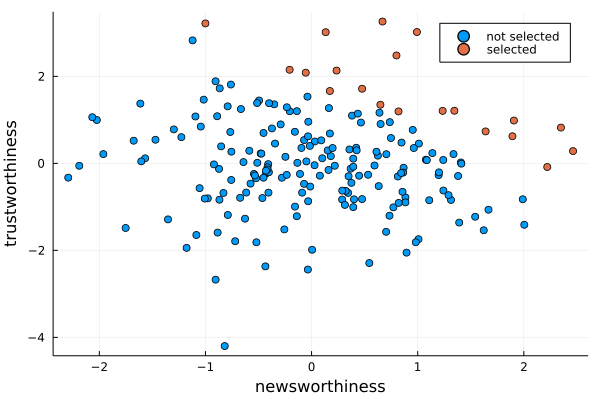

In [24]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [28]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

Code 6.3

In [30]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6338  0.3296    0.091  0.6329  1.1752   ▁▁▁▃▅██▆▃▂▁▁ │
│    bl │ 1.7655    1.96  -1.4323  1.8123  4.8364  ▁▁▂▂▅▇██▅▄▂▁▁ │
│    br │ 0.3122  1.9688   -2.772  0.2748  3.4925  ▁▁▂▄▅██▇▅▃▂▁▁ │
│     σ │ 0.6126  0.0449   0.5446  0.6099  0.6885         ▂▇█▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.4

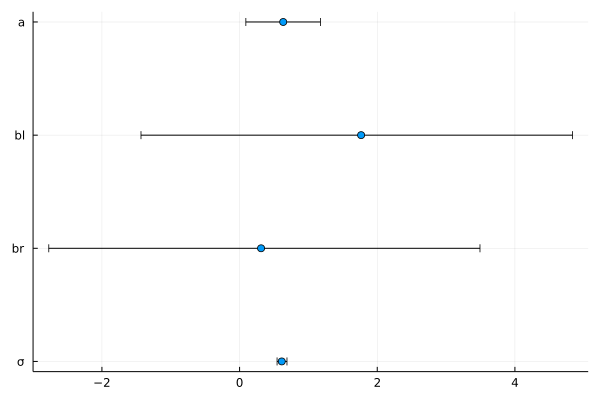

In [31]:
coeftab_plot(m6_1_df)

Code 6.5

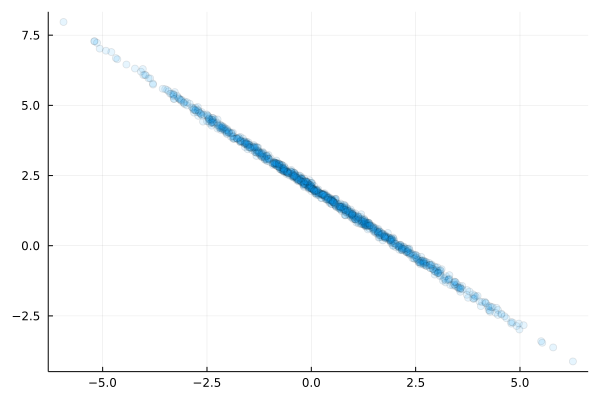

In [33]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1)

Code 6.6

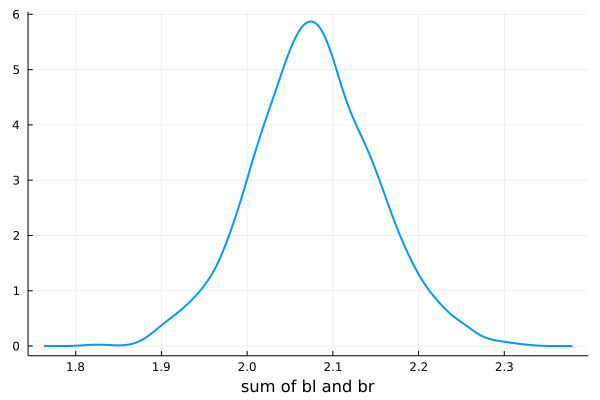

In [36]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

Code 6.7

In [37]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6728   0.327  0.1407  0.6611  1.1928    ▁▁▁▂▅▇█▇▄▂▁▁ │
│    bl │ 2.0684  0.0712   1.956  2.0689  2.1783      ▁▁▂▄▇█▆▃▁▁ │
│     σ │ 0.6063  0.0414  0.5434  0.6051  0.6753  ▁▁▂▄▇██▆▄▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


In [43]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(1.9600064957206784, 1.9687730215545687, 0.07174624055531233)